<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both"></hr>
<h1><font color='black'>Functional Connectivity, Graphs and Connectomes</font></h1>


## 0. Relevant Packages

Below are the required packages for this lab, let's import them !

In [1]:
#This section imports the needed libraries and defines the used functions:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
from nilearn.datasets import fetch_atlas_aal, fetch_development_fmri
from nilearn.plotting import plot_epi, plot_roi, plot_stat_map, plot_connectome, plot_matrix

from skimage.morphology import binary_dilation

import networkx as nx

import warnings
# Suppress some DeprecationWarnings from nilearn (mostly in AAL fetcher)
warnings.filterwarnings("ignore", category=DeprecationWarning)

<div class = 'alert alert-info'>
This lab is a short introduction to the fields of Network Neuroscience and Connectomics; i.e., the analysis of brain graphs.
</div>

# 1. Functional Connectivity

<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Introducing Functional Connectivity</b></p>
        <p style='text-indent: 10px;'> Functional connectivity maps how much pairs of brain regions share information from brain activity. One of the most popular approach to estimate functional connectivity through the Pearson correlations between the average activity of <i>N</i> selecteds brain regions. The resulting is a matrix of size [<i>N</i> x <i>N</i>] that captures the functional interactions between each pair of regions summarized as a weight of connectivity strenght. As seen in the class, this matrix also is the mathematical representation (adjacency matrix) of a weighted graph of <i>N</i> nodes that is commonly called a <b>functional connectome</b>.</p>
    </span>
</div>

For this lab, we will make use of the developmental dataset of [Richardson, et al. 2018](https://www.nature.com/articles/s41467-018-03399-2) that can be easily accessed using NiLearn. To make it simple, we will only load a single adult participant from the dataset (`n_subjects=1` and `age_group='adult'`), but you are free to play around and load multiple participants (see the details on [NiLearn's Documentation](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_development_fmri.html#nilearn.datasets.fetch_development_fmri)).
- You first task to get familiar with the structure of the dataset is to access the filename and load the functional image to be plotted below and used for the rest of the lab.

[fetch_development_fmri] Dataset found in /Users/acionca/nilearn_data/development_fmri

[fetch_development_fmri] Dataset found in /Users/acionca/nilearn_data/development_fmri/development_fmri

[fetch_development_fmri] Dataset found in /Users/acionca/nilearn_data/development_fmri/development_fmri

fMRI data has shape (50, 59, 50, 168)


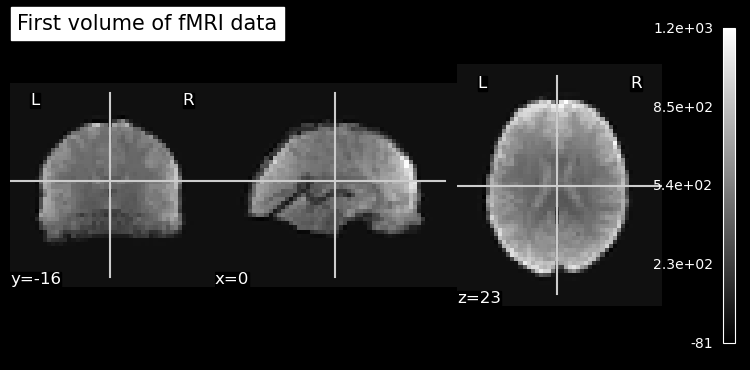

In [2]:
# Downloading one adult participant of the developmental fMRI dataset
development_dataset = fetch_development_fmri(n_subjects=1, age_group='adult')

### YOUR CODE HERE
func_img_fname = development_dataset.func[0] ### YOUR CODE HERE
func_img = nib.load(func_img_fname) ### YOUR CODE HERE
n_scans = func_img.shape[3] ### YOUR CODE HERE
### END OF SOLUTION

print(f"fMRI data has shape {func_img.shape}")

first_fmri_img = func_img.slicer[:, :, :, 0]
plot_epi(first_fmri_img, title="First volume of fMRI data")

### 1.1 Voxel to Voxel Interactions

The first and most straightforward approach would be to consider one single voxel as a seed and compute its correlation with the activity of all the other possible voxels, right ? Then repeating the process for all voxels, we'll end up with a map (network) of interactions between voxels based on the brain activity.

But let's just not do it, ok ? Why ? Consider our current fMRI data with a shape of $[50 \times 59 \times 50 \times N_{timepoints}]$. There are $147'500$ voxels and we are trying to compute the correlation between each pair of voxels, which makes it $(147'500 \times 147'499)/2 = 10'878'051'250 = 10.8\text{B}$ computations. More than that, how could we possibly interprete and draw conclusions from a graph of $147\text{K}$ nodes and $10.8\text{B}$ edges (for a single individiual) ? You will see in the next section that whole brain statistical maps are not always straightforward to digest.

We can use something much more powerful that is the functional or anatomical priors given by brain atlases.

---

### 1.2 Region to Voxel Interactions (Seed-Based Functional Connectivity)

It is usually assumed that voxels within a brain region behave similarly in time. Therefore, we can average the activity of all the voxels in one region to get a single timecourse for this region and then compare it to the ones of other regions. The fMRI data of size $[N_{voxels}\times T_{timepoints}]$ can thus be summarized into atlased (or parcelated) timeseries of size $[N_{regions}\times T_{timepoints}]$ where $N_{regions} << N_{voxels}$.

For this lab, we will use the AAL parcellation that you know well, let's first load it.

In [3]:
# To Remove
def make_aal_regions_info():
    """Generate a TSV file with AAL region info: ID, name, number of voxels, and center coordinates."""
    aal_atlas = fetch_atlas_aal()

    aal_img = nib.load(aal_atlas.maps)
    aal_data = aal_img.get_fdata()

    aal_df = pd.DataFrame({'id': aal_atlas.indices, 'region': aal_atlas.labels})

    # Generating number of voxels and center coordinates for each region
    for aal_id in aal_atlas.indices:
        region_mask = (aal_data == int(aal_id))

        region_coords = np.array(np.where(region_mask)).T
        voxel_center = region_coords.mean(axis=0)
        region_center = aal_img.affine.dot(np.append(voxel_center, 1))[:3]

        num_voxels = np.sum(region_mask)
        aal_df.loc[aal_df['id'] == aal_id, 'num_voxels'] = num_voxels
        aal_df.loc[aal_df['id'] == aal_id, ['x', 'y', 'z']] = region_center

    aal_df.to_csv('./FC_graphs_data/aal_regions_info.tsv', index=False, sep='\t')

In [4]:
# Load AAL atlas and region info
aal_atlas = fetch_atlas_aal(version="SPM12")
aal_atlas_img = nib.load(aal_atlas.maps)
aal_regions_info = pd.read_csv('./FC_graphs_data/aal_regions_info.tsv', sep='\t')

print(aal_regions_info.shape)
# Removing Cerebellum regions for simplicity
aal_regions_info = aal_regions_info.iloc[1:91]
aal_regions_info.head()

[fetch_atlas_aal] Dataset found in /Users/acionca/nilearn_data/aal_SPM12

(117, 6)


id             region  num_voxels          x          y          z
1  2001       Precentral_L      3526.0 -38.930233  -6.961429  49.640386
2  2002       Precentral_R      3381.0  41.100858  -9.549837  50.809820
3  2101      Frontal_Sup_L      3599.0 -18.772992  33.489858  40.954154
4  2102      Frontal_Sup_R      4056.0  21.603057  29.910256  42.504438
5  2111  Frontal_Sup_Orb_L       963.0 -16.824507  45.919003 -14.718588

Now we need to define a suitable seed for our analysis, let's consider the Posterior Cingulate Cortex (PCC) that is known to be one of the central hubs of the Default Mode Network (DMN).

- As a recap' of some of the first labs, your first task is to generate a 3D mask that has value $1$ if a voxel is in the seed region (the label is in `seed_name`) and $0$ otherwise. In the previous cell, we define the `aal_regions_info` dataframe where each row is a region of the *AAL* atlas with its corresponding `id` (voxel value in the atlas volume) and `region` name. Make sure to integrate the regions from the left and right hemisphere !

<div class = 'alert alert-info'>

**Hint:** Find what are the IDs that correspond with regions that include the seed name, then create the mask volume with a 1 if a voxel has either of these IDs as values and 0 otherwise.
</div>

In [5]:
seed_name = "Cingulum_Post" # _L AND _R

### YOUR CODE HERE
seed_ids = [row.id for _, row in aal_regions_info.iterrows() if seed_name in row.region]
seed_mask = np.isin(aal_atlas_img.get_fdata(), seed_ids)
### END OF SOLUTION

# We dilate the seed region once for better visualization
seed_mask = binary_dilation(seed_mask)

seed_img = nib.Nifti1Image(seed_mask.astype(np.int16), aal_atlas_img.affine)

Let's visualize our seed on top of the first fMRI frame.

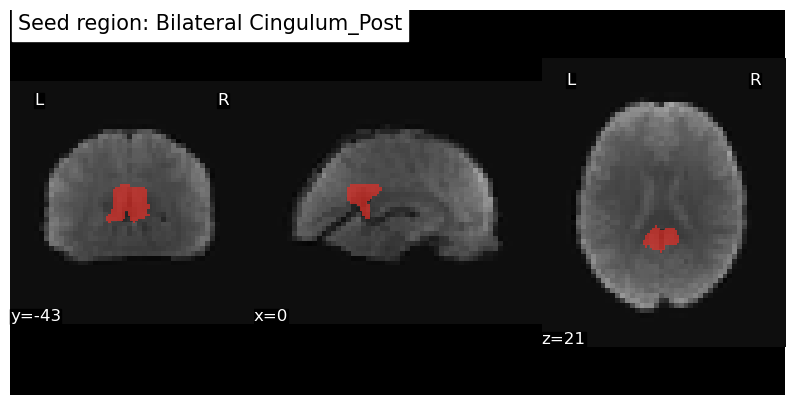

In [6]:
# Note the plotting might take ~20 seconds
fig, axes = plt.subplots(figsize=(10, 5))
plot_roi(seed_img, bg_img=first_fmri_img,
         title=f'Seed region: Bilateral {seed_name}',
         cmap='Reds', vmin=0, vmax=1.5, draw_cross=False,
         axes=axes, colorbar=False)

Is our seed looking good ? Is it properly showing in both hemispheres ? Do you see a significant difference between the background image and the seed image ?

---

Our next step is to aggregate and average the voxel activity within the seed to generate a single timeserie for our seed. As observed above, it is however usual to have atlas images at higher resolution (smallest voxel size) than the typical fMRI spatial resolution. As such, we first need to resample the mask in the resolution of the fMRI data before computing the average seed activity. Luckily, NiLearn already has multiple `maskers` classes that allow us to define masks, resample them in various resolutions and aggregate the functional data within these masks.

- For this task, have a look at the documentation of [NiLearn's NiftiLabelsMasker class](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiLabelsMasker.html) and fill the gaps below to properly define our mask generate our seed's timeserie.

<div class = 'alert alert-info'>

**Note:** You can do this task without using NiLearn's maskers, if you wish to implement it on your own, you may have a look at NiLearn's `image` module and especially at [`resample_to_img`](https://nilearn.github.io/stable/modules/generated/nilearn.image.resample_to_img.html#nilearn.image.resample_to_img).
</div>

In [7]:
from nilearn.maskers import NiftiLabelsMasker

### YOUR CODE HERE
TR = func_img.header.get_zooms()[3].astype(float) ### YOUR CODE HERE
masker = NiftiLabelsMasker(
    labels_img=seed_img, ### YOUR CODE HERE
    resampling_target="data", ### YOUR CODE HERE
    t_r=TR,
    detrend=True,
    standardize="zscore_sample",
)
seed_time_series = masker.fit_transform(func_img_fname) ### YOUR CODE HERE
### END OF SOLUTION

Let's visualize the average brain activity within our selected seed.

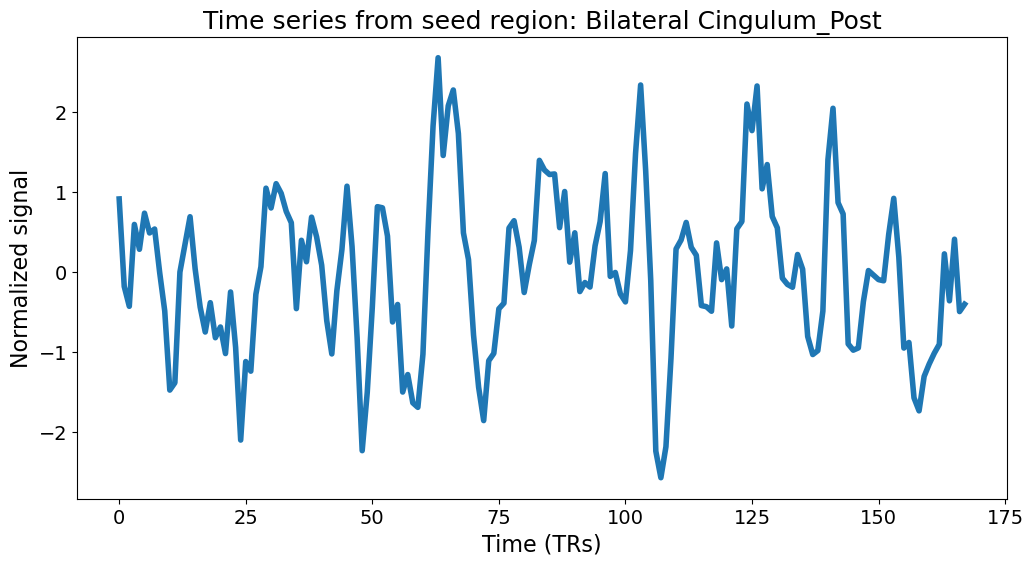

In [8]:
fig, axes = plt.subplots(figsize=(12, 6))

axes.plot(seed_time_series, lw=4, zorder=2)

axes.set_title(f'Time series from seed region: Bilateral {seed_name}', fontsize=18)
axes.set_xlabel('Time (TRs)', fontsize=16)
axes.set_ylabel('Normalized signal', fontsize=16)
axes.tick_params(labelsize=14)

Feel free to play around with the different arguments of `NiftiLabelsMasker` such as the filtering, detrending, confounds options to see how it affects the seed timeserie.

---

Let us now investigate what parts of the brain would correlate and be synchronized with our seed. The idea is to compute the correlation between our seed's activity and the activity of each individual voxel in the brain. But it sounds like something we did before, no ? Can you remember the topic of lab 5 ? Something about a [pig getting fat](https://raw.githubusercontent.com/Shrecki/NX_NSSP_public/refs/heads/main/Week05/imgs/pig_couch.jpg) ...

Seed-based connectivity can actually be seen as a **GLM** but instead of having task events, paradygms and HRF convolutions, we simply build a design matrix where our only regressor of interest (or condition) is our seed's timeserie. Let's recall what we did in the $5^\text{th}$ lab and implement our first model analysis.

- Your task here is to generate a design matrix by adding our seed's timeserie as an added regressor, then to define the contrast associated this specific regressor only. You are free to play around with the other parameters of the first level analysis.

<div class = 'alert alert-info'>

**Hint:** Have a look at the `add_regs` and `add_reg_names` arguments.
</div>

In [9]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

### YOUR CODE HERE
frametimes = np.linspace(0, (n_scans - 1) * TR, n_scans) ### YOUR CODE HERE
design_matrix = make_first_level_design_matrix(
    frametimes,
    hrf_model="spm",
    add_regs=seed_time_series, ### YOUR CODE HERE
    add_reg_names=[f"{seed_name}_seed"], ### YOUR CODE HERE
)

seed_contrast_array = np.array([1] + [0] * (design_matrix.shape[1] - 1)) ### YOUR CODE HERE
contrasts = {"seed_based_glm": seed_contrast_array}
### END OF SOLUTION

Let's run and plot the whole model in the two next cells.

In [10]:
first_level_model = FirstLevelModel()
first_level_model = first_level_model.fit(run_imgs=func_img, design_matrices=design_matrix)

z_map = first_level_model.compute_contrast(contrasts["seed_based_glm"], output_type="z_score")

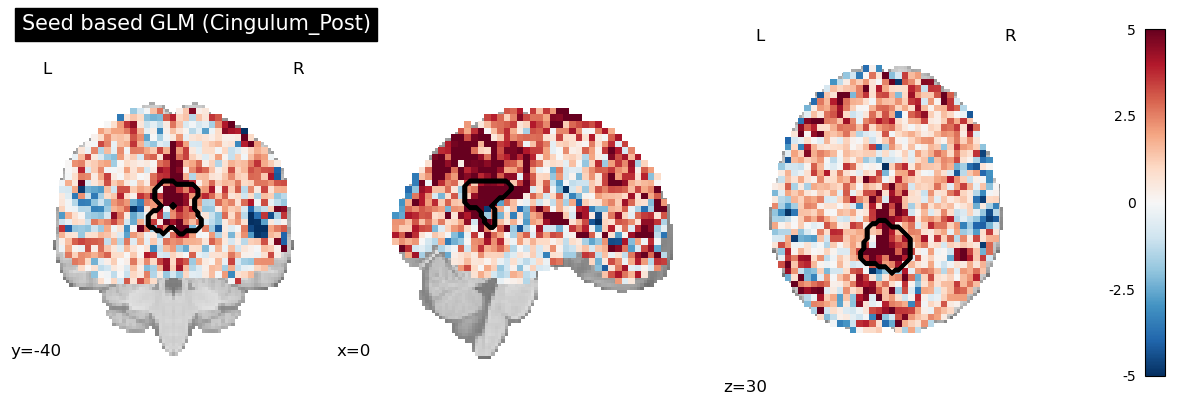

In [11]:
fig, axes = plt.subplots(figsize=(15, 5))
# The plot will take ~40s to render
display = plot_stat_map(z_map, title=f"Seed based GLM ({seed_name})", draw_cross=False,
                        vmax=5, cut_coords=(0, -40, 30), axes=axes)
display.add_contours(seed_img, colors='k')

Looks good, right ? Now that you've become an expert in seeing fMRI volumes, can you comment on the preprocessing steps that might have happened or not ? Does this map look "smooth" ?

From this statistical map, one could think about identifying the regions with particularly high or low correlation values. However, we will directly assess this by directly computing the interaction between each pair of brain regions; namely region-to-region interactions; namely the **functional connectivity**.

---

### 1.3 Region to Region Interactions (Functional Connectivity)

In the previous chapter, we made use of NiLearn's `NiftiLabelsMasker` to aggregate data from our selected seed. We now wish to investigate the functional network that are correlating across the brain by looking at region-to-region interactions; the functional connectivity.

- Your task here is to extract the timeseries for each of the 90 regions in our atlas (*AAL*) by adapting our previous use of `NiftiLabelsMasker` to more than a single seed.

In [12]:
### YOUR CODE HERE
all_roi_masker = NiftiLabelsMasker(
    labels_img=aal_atlas_img,
    resampling_target="data",
    t_r=TR,
    detrend=True,
    standardize="zscore_sample",
)
roi_timeseries = all_roi_masker.fit_transform(func_img_fname)

# Again, we remove the cerebellum regions for consistency
roi_timeseries = roi_timeseries[:, :90]
### END OF SOLUTION

Let's now visualize the extracted signals evenly separated into 8 arbitrary groups or regions.

Text(0.5, 1.0, 'Region-wise time series from AAL atlas')

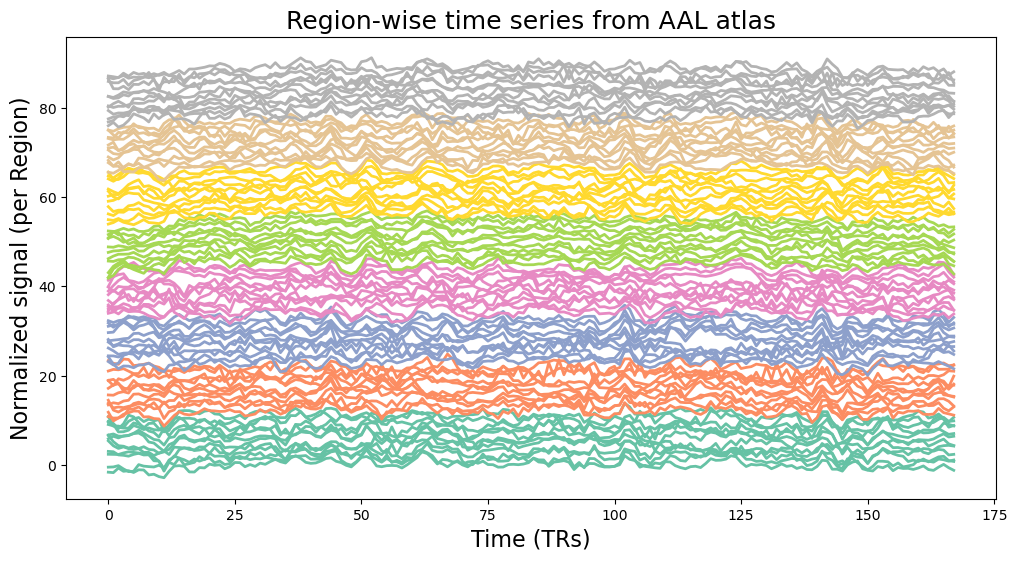

In [13]:
single_subject_ts = roi_timeseries.copy()
timeseries_plot = np.arange(single_subject_ts.shape[1])[np.newaxis] + single_subject_ts

fig, axes = plt.subplots(figsize=(12, 6))
ts_colormap = plt.get_cmap('Set2', single_subject_ts.shape[1])
for t_i, ts in enumerate(timeseries_plot.T):
    axes.plot(ts, lw=2, zorder=2, color=ts_colormap(t_i))

axes.set_ylabel('Normalized signal (per Region)', fontsize=16)
axes.set_xlabel('Time (TRs)', fontsize=16)
axes.set_title('Region-wise time series from AAL atlas', fontsize=18)

Nice ! We now have our $90$ regional timeseries, the grouping from above is only linked to the ordering of the regions in the atlas and does not really represent regions that consistenly interact with each-other. Let's properly evaluate that throught the functional connectivity.

---

To investigate the functional relationship between brain regions, we wish to compute the functional connectivity (here defined as the Pearson correlation coefficient).

- Your task is to fill in the `ComputeAdjacency` method below to compute the pairwise functional connectivity between brain regions from their individual timeseries.


<div class = 'alert alert-info'>

**Hint:** To help you, have a look as [`corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) from Numpy or the [`ConnectivityMeasure`](https://nilearn.github.io/stable/modules/generated/nilearn.connectome.ConnectivityMeasure.html#nilearn.connectome.ConnectivityMeasure) class from NiLearn.

**Note:** Don't forget to set the diagonal values of the matrix to zero and make sure the output has the correct shape !
</div>

In [14]:
from nilearn.connectome import ConnectivityMeasure

def ComputeAdjacency(X):
    ### YOUR CODE HERE
    correlation_measure = ConnectivityMeasure(kind="correlation", standardize="zscore_sample",)
    fc_matrix = correlation_measure.fit_transform([X])[0]
    
    # Old code:
    # fc_matrix = np.corrcoef(X)
    
    np.fill_diagonal(fc_matrix, 0)
    ### END OF SOLUTION
    
    return fc_matrix

fc_matrix = ComputeAdjacency(roi_timeseries)
n_nodes = fc_matrix.shape[0]

(<Figure size 1200x1200 with 2 Axes>,
 <Axes: title={'center': 'Functional Connectivity Matrix'}>)

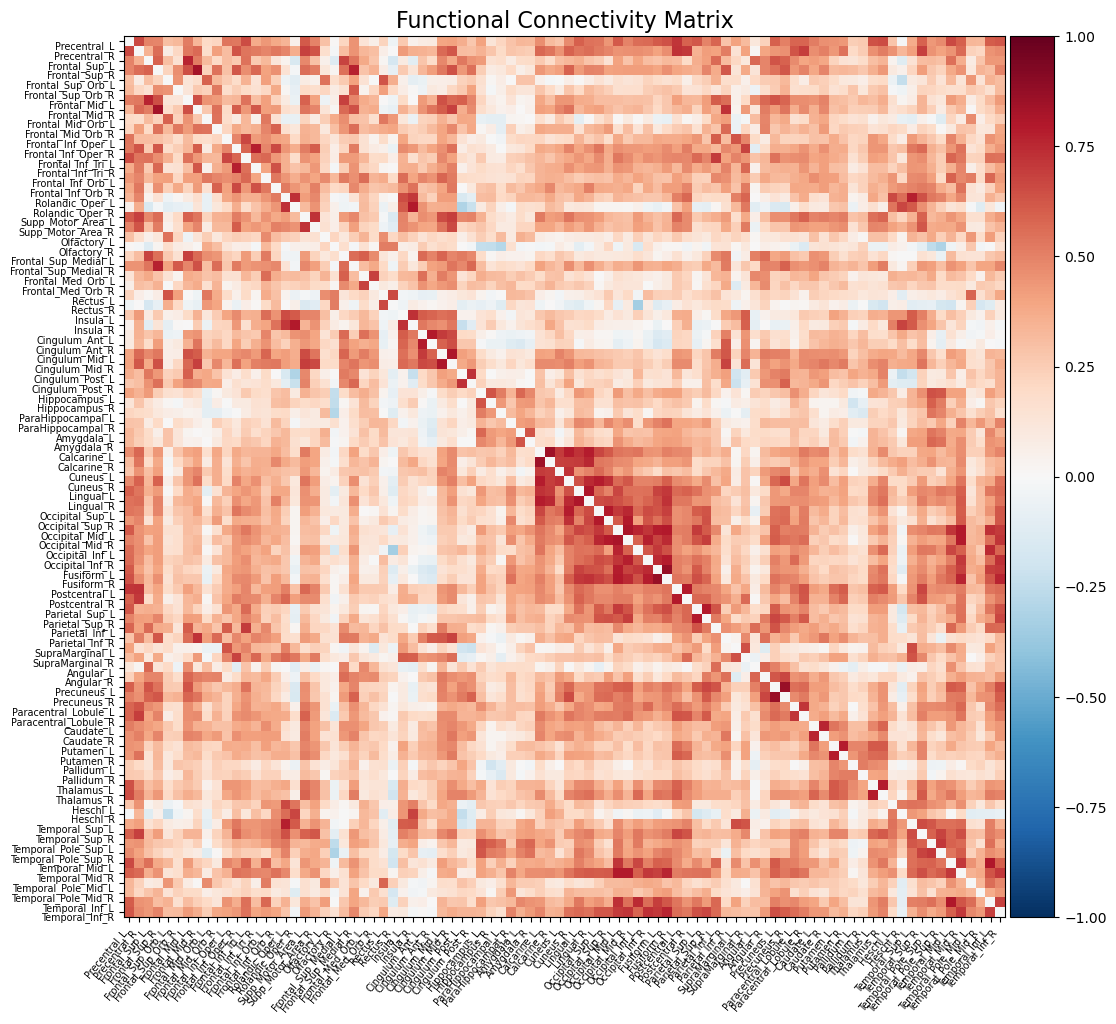

In [15]:
def plot_single_adjacency(adjacency, labels=True):
    fig, axes = plt.subplots(figsize=(12, 12))
    plot_matrix(adjacency, axes=axes,
                title="Functional Connectivity Matrix",
                labels=aal_regions_info.region.values if labels else None,
                vmin=-1, vmax=1, colorbar=True)
    axes.tick_params(axis="y", rotation=0)
    
    return fig, axes

plot_single_adjacency(fc_matrix)

How does the functional connectivity matrix look like ? Can you identify groups of regions that are densely connected (patches of darker red) ? What is your interpretation of negative correlation values ? Do you observe regions that are particularly (dis-) connected with the rest of the brain ?

We will now investigate how stable is this matrix when compared with other participants in the dataset. Good thing is we already computed the regional timeseries and functional connectivity matrices for the 33 adults participants. Let's load and visualize some of them to evaluate individual differences.

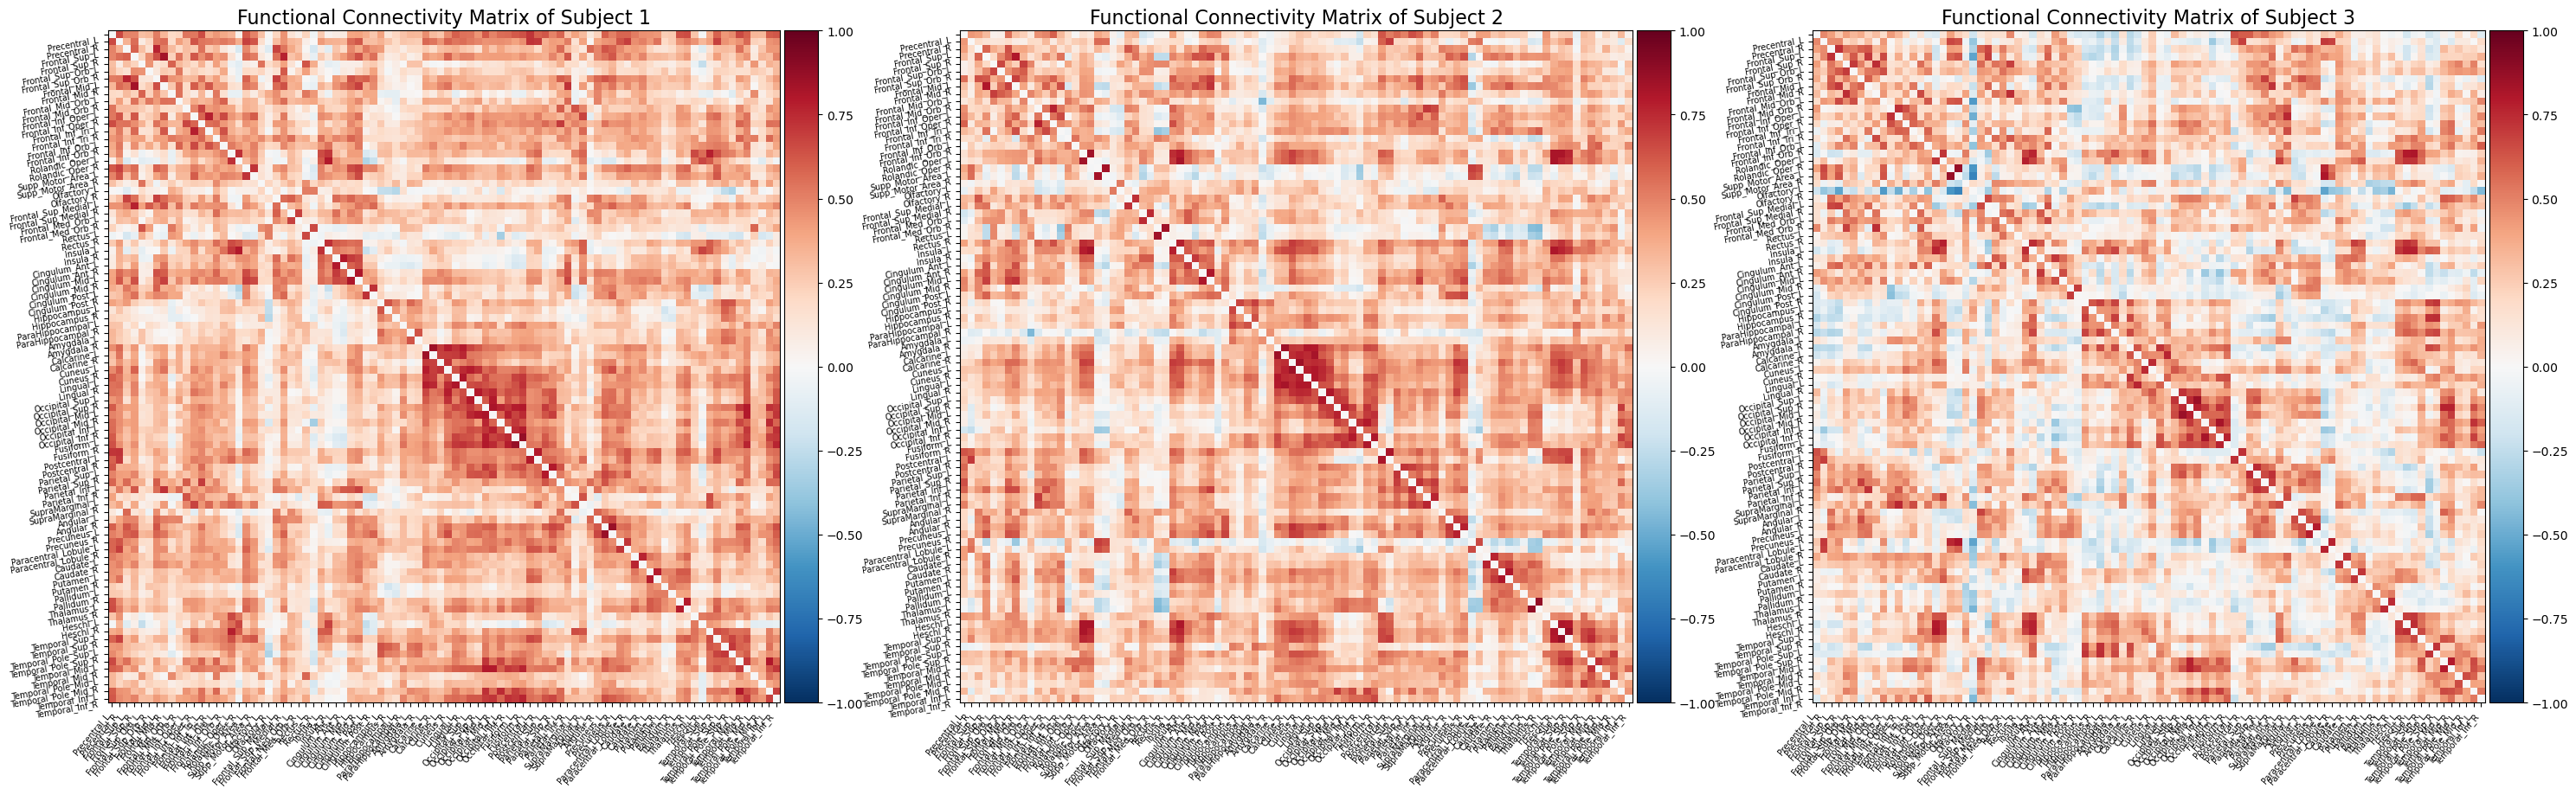

In [16]:
fc_matrices = np.load('./FC_graphs_data/fc_matrices.npy')
n_subjects = fc_matrices.shape[0]

show_n_subj = 3

fig, axes = plt.subplots(ncols=show_n_subj, figsize=(12*show_n_subj, 12))

for i, adjacency in enumerate(fc_matrices[:show_n_subj]):
    plot_matrix(adjacency, axes=axes[i],
                title="Functional Connectivity Matrix of Subject {}".format(i+1),
                labels=aal_regions_info.region.values,
                vmin=-1, vmax=1, colorbar=True)

Take a close look at the adjacency matrices plotted above. Do you observe recurrent patterns of high functional connectivity? Look in particular at occipital regions (Calcarine, Cuneus, Lingual, etc).

Alternatively and as seen in the lecture, these matrices of interaction can be used as adjacency matrices to define a brain graphs; i.e., a connectomes. Let's visualize it !

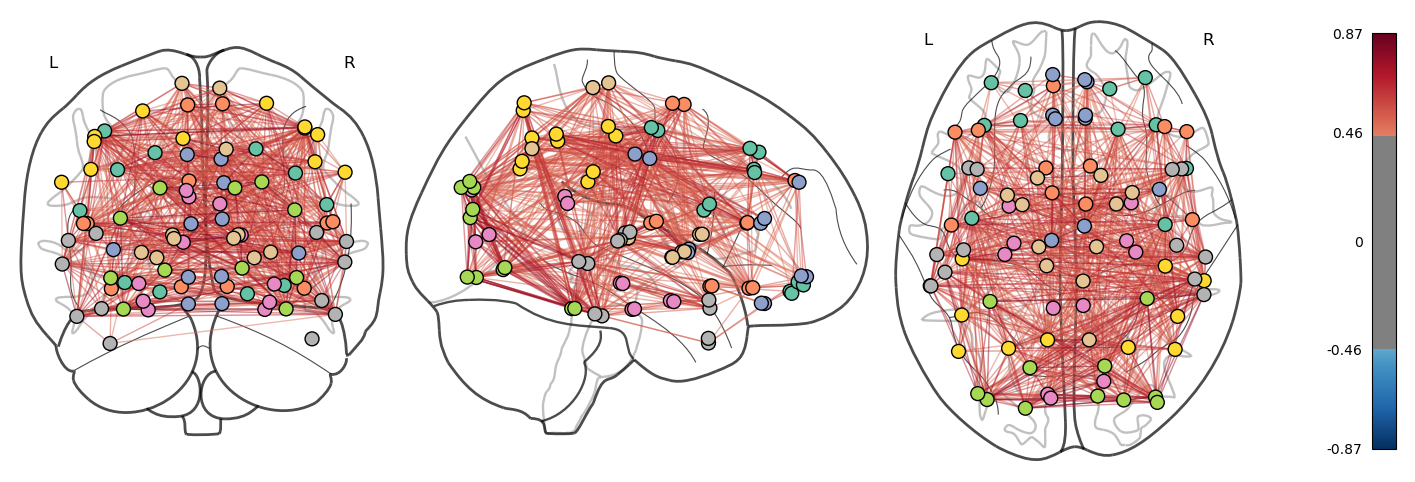

In [17]:
fig, axes = plt.subplots(figsize=(18, 6))

plot_connectome(fc_matrix, node_coords=aal_regions_info[['x', 'y', 'z']].values,
                node_size=100,
                edge_threshold="80%",
                edge_kwargs={'alpha':0.5, 'linewidth': 1},
                node_kwargs={'edgecolor':'k'},
                colorbar=True, axes=axes)

Looks cool, right ? Again, the colouring of the graph nodes (brain regions) is arbitrary and linked to the ordering of the labels in the atlas, but it still shows some regional homogeneities.

Congratulation, you succesfully computed functional connectivity matrices from preprocessed fMRI ! Now let's play around with these functional connectomes (brain graphs) and see how principles from network science and graph theory can help us understand the brain's functional organisation.

# 2. Connectomics

## 2.1 Binary Graphs

Before computing graph metrics, connectivity matrices can be binarized, switching from the "strength of connectivity" to the "is connected" perspective. This is typically made by removing weak edges until a desired edge density is achieved.

- Your task is to fill in the `BinarizeAdjacency` method, which takes a weighted connectivity matrix and a density fraction value (in the range $[0,1]$) as inputs, and returns a binary connectivity matrix. For example, a $0.5$ density value means that only the $50\%$ strongest connections must be retained in the output matrix. Since the Pearsons correlation is a symmetric measure, the connectivity matrix $\mathbf{A}$ is also symmetric ($a_{i \to j}=a_{j \to i}$), thus we only consider the upper diagonal elements of the matrix (excluding diagonal elements themselves) for the calculations.

<div class = 'alert alert-info'>

**Note:** the function already includes certain lines of code at the beginning and the end of the body, respectively converting a matrix's upper entries into a vector, and converting a vector into a symmetric matrix.

**Hint:** You can use the function [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) to sort the indices (pay attention to the default sorting type). 
</div>

In [18]:
def BinarizeAdjacency(A, rho):
    
    # The following three lines already extract off-diagonal entries (upper triangle) in a vector `A_vec`
    N = A.shape[0]

    ind = np.triu_indices(N, k=1)
    A_vec = A[ind] 
    
    # Declare output vector A_vec_bin
    A_vec_bin = A_vec.copy()

    ### YOUR CODE HERE
    threshold = np.quantile(A_vec, (1 - rho))
    A_vec_bin[A_vec_bin <= threshold] = 0
    A_vec_bin[A_vec_bin > threshold] = 1
    ### END OF SOLUTION
    
    # The following lines convert the vector of off-diagonal entries back into a matrix
    A2 = np.zeros((N, N), dtype=int)
    A2[ind] = A_vec_bin
    # Fill the lower triangle
    A2 = A2 + A2.T
    
    # Make sure diagonal is zero
    np.fill_diagonal(A2, 0)
    
    return A2

Let's test your implementation on the adjacency matrix `fc_matrix` that you computed before and visualize the results. You can use various arguments of `plot_matrix` from *NiLearn* for visualization.

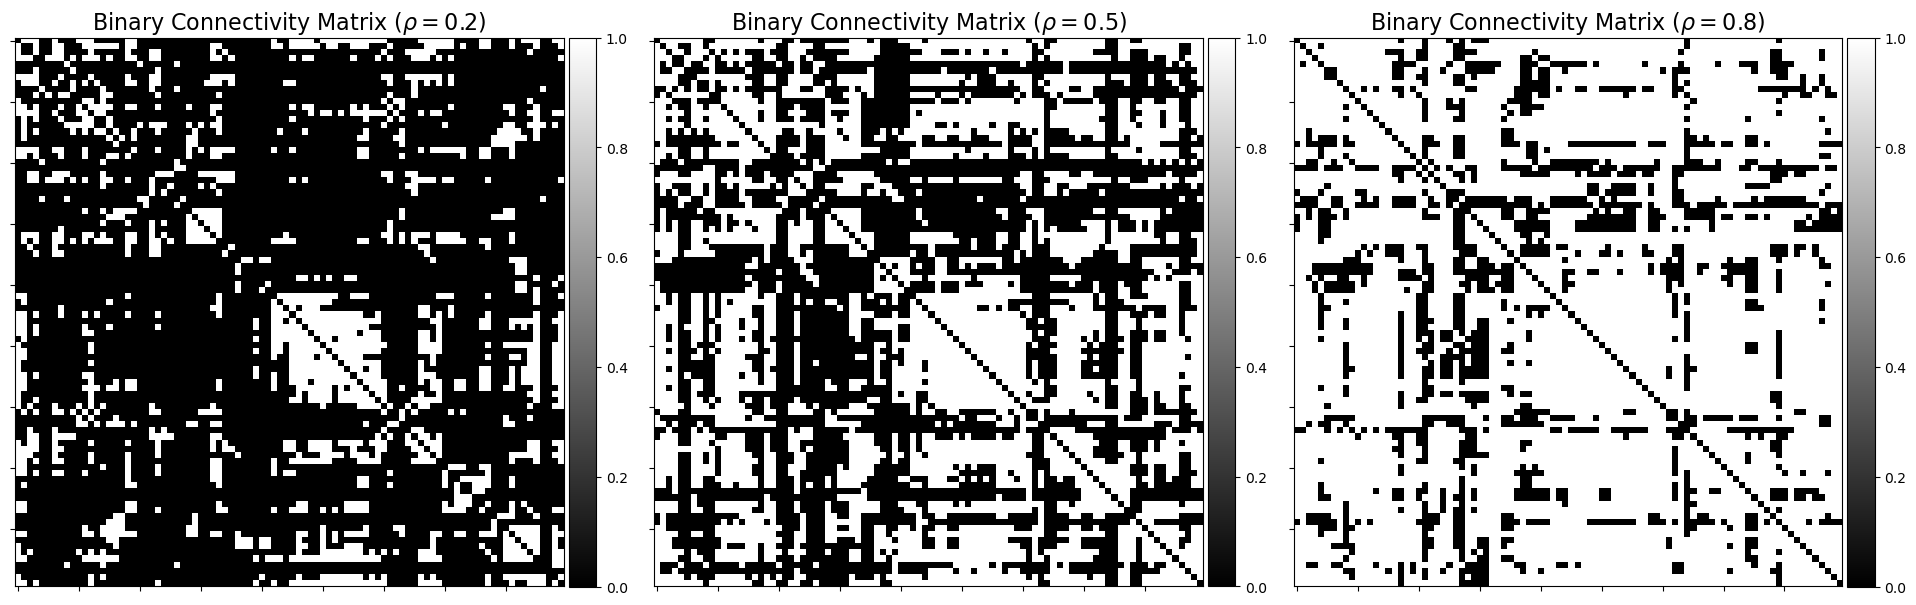

In [19]:
all_densities = [0.2, 0.5, 0.8]

fig, axes = plt.subplots(ncols=len(all_densities), figsize=(8*len(all_densities), 8), gridspec_kw={'wspace':0.1})

for i, density in enumerate(all_densities):
    ### YOUR CODE HERE
    binary_adj = BinarizeAdjacency(fc_matrix, density) ### YOUR CODE HERE
    ### END OF SOLUTION
    plot_matrix(binary_adj,
                axes=axes[i],
                title=f"Binary Connectivity Matrix $(\\rho={density})$",
                labels=None,
                colorbar=True,
                cmap="binary_r")

<div class = 'alert alert-info'>

**Note:** In this exercise we are considering only positive correlations (for easier interpretations), however it's common practise to consider the absolute values of the matrix because also regions that are strongly negative correlated could be interpreted as inhibition. This interpretation still remains debatable and yet to be tested.
    
For fun, you can try yourself using the absolute values to threshold and see what happens.
</div>

## 2.2 Graph Metrics Evaluation

Now that we have preprocessed and binarized the adjacency matrix, we can start playing with network metrics. The metric that we will mainly consider is the nodal clustering coefficient defined for a graph node $i$ as
$$c[i]=\frac{2e[i]}{k[i](k[i]-1)},$$
where $k[i]$ is the degree of node $i$ and $e[i]$ is the number of edges in the neighborhood of $i$ (number of edges that connect the neighboring nodes of $i$). The clustering coefficient captures how much connected is the neighborhood of a specific nodes and is closely related to the question of "how densely connected is this neighborhood ?".

- Your task it to fill the function `ClustCoef` that takes a binary adjacency matrix of size $N\times N$ as input and returns a vector of size $N$ whose elements are the clustering coefficient for each node.

<div class = 'alert alert-info'>

**Hint:** Feel free to implement the clustering coefficient yourself or have a look at <i>NetworkX</i>'s `nx.algorithms.cluster.clustering` module(see [documentation here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering)). With <i>NetworkX</i>'s implementation, you might want to use `nx.Graph(my_array)` to convert a <i>Numpy</i> array into a <i>NetworkX</i> graph.
</div>

In [20]:
def ClustCoef(adj1):
    
    ### YOUR CODE HERE
    clcoefs = nx.algorithms.cluster.clustering(nx.convert_matrix.from_numpy_array(adj1.astype(int)))
    clcoefs = np.asarray(list(clcoefs.values()))
    ### END OF SOLUTION
    
    return clcoefs

Now, and to test your implementation, we will compute the nodal clustering coefficient at different edge densities (from 0.05 to 1, by increments of 0.05) for all 33 subjects.

In [21]:
all_rho = np.arange(0.05, 1, 0.05)

c = np.zeros((n_subjects, len(all_rho), n_nodes))
for sub, mat in enumerate(fc_matrices):
    for rho_ind, r in enumerate(all_rho):
        adj = BinarizeAdjacency(np.squeeze(mat), r)
        c[sub, rho_ind, :] = ClustCoef(adj)

Observe the outcome by plotting all the 90 nodal traces as a function of edge density for a few subjects (you can change the subjects by changing the `subjects_to_plot` list). Each line in the following plots corresponds to one of the 90 nodes in the graph (with our usual arbitrary coloring).

Text(0, 0.5, 'Clustering Coefficient')

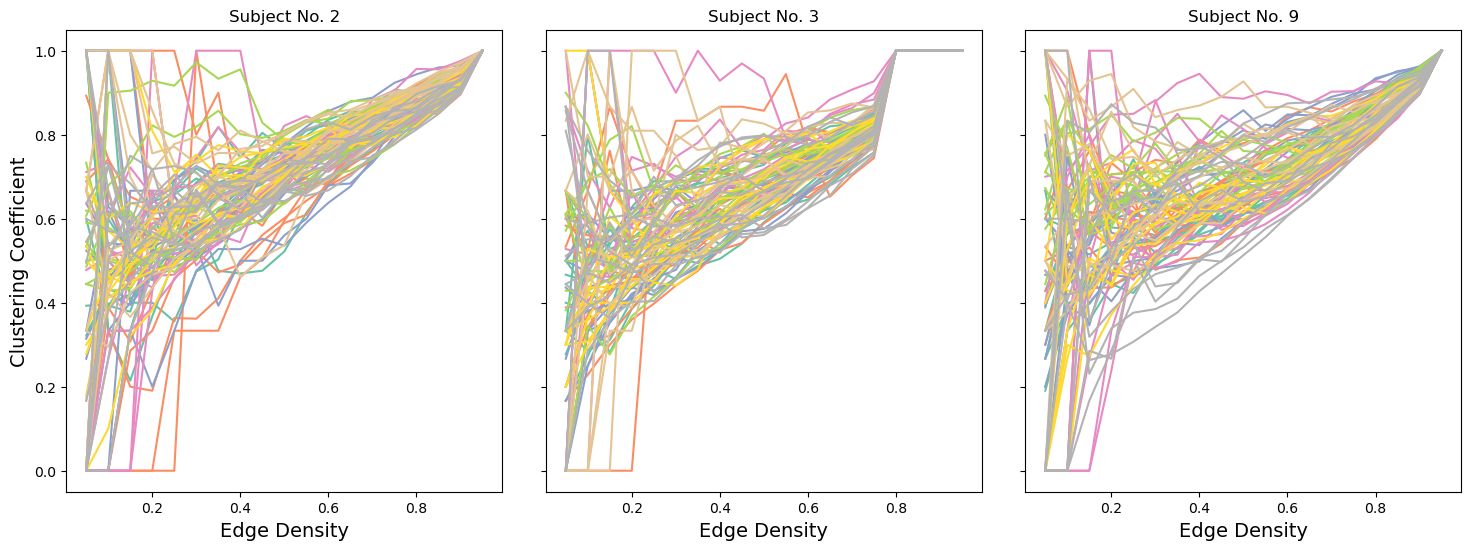

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6), sharey=True, gridspec_kw={'wspace':0.1})

subjects_to_plot = [1, 2, 8]

cmap = plt.get_cmap('Set2', n_nodes)
for i, sub in enumerate(subjects_to_plot[:3]):
    for node in range(n_nodes):
        axes[i].plot(all_rho, c[sub, :, node], color=cmap(node))

    axes[i].set_xlabel("Edge Density",fontsize=14)
    axes[i].set_title(f"Subject No. {sub + 1}")

axes[0].set_ylabel("Clustering Coefficient",fontsize=14)

What can you say about these plots ? Can you see a general trend of high clustering coefficient for a specific edge density ?

These are not trivial to observe... Maybe we could compare these traces with random graphs that do not have apparent clusters.

---

Let's do exactly that - we will now try to compare the obtained results with the ones of a random graph model with similar edge density. Can you remember the Erdös-Rényi model of random graph from the lecture ? The idea is to generate such a graph for each edge density value tested before and to compute the clustering coefficient in these graphs. We can then compare the evolution of clustering coefficient (as a function of edge density) in the real graph and in the random graph by computing the ratio between the two.

- Your task is to complete the next cell to generate random graphs of 90 nodes for each density values that we tested above. Then, and for each random graph, compute the clustering coefficient and store it in the `c_rand` array.

<div class = 'alert alert-info'>

**Hint:** Taks a look at documentation of [`networkx.erdos_renyi_graph`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph) that can help you create such a graph. Be careful with the type of input or output data (`nx.Graph` or `np.array`).

**Note:** The clustering might take a few seconds ;)

</div>

In [23]:
c_rand = np.zeros((n_subjects, len(all_rho), n_nodes))
for sub, _ in enumerate(fc_matrices):
    for i, edge_density in enumerate(all_rho):
        ### YOUR CODE HERE
        rand_graph = nx.erdos_renyi_graph(n_nodes, edge_density)
        rand_adj = nx.adjacency_matrix(rand_graph).todense()
        c_rand[sub, i, :] = ClustCoef(rand_adj) ### YOUR CODE HERE
        ### END OF SOLUTION

real_to_rand_ratio = np.divide(c, c_rand, out=np.zeros_like(c), where=c_rand!=0)

# Computing the average ratio across subjects
c_average = np.mean(real_to_rand_ratio, axis=0)
c_rand_average = np.mean(c_rand, axis=0)

Let us now visualize the evolution of this ratio, for all nodes, with increasing edge density and averaging across subjects.

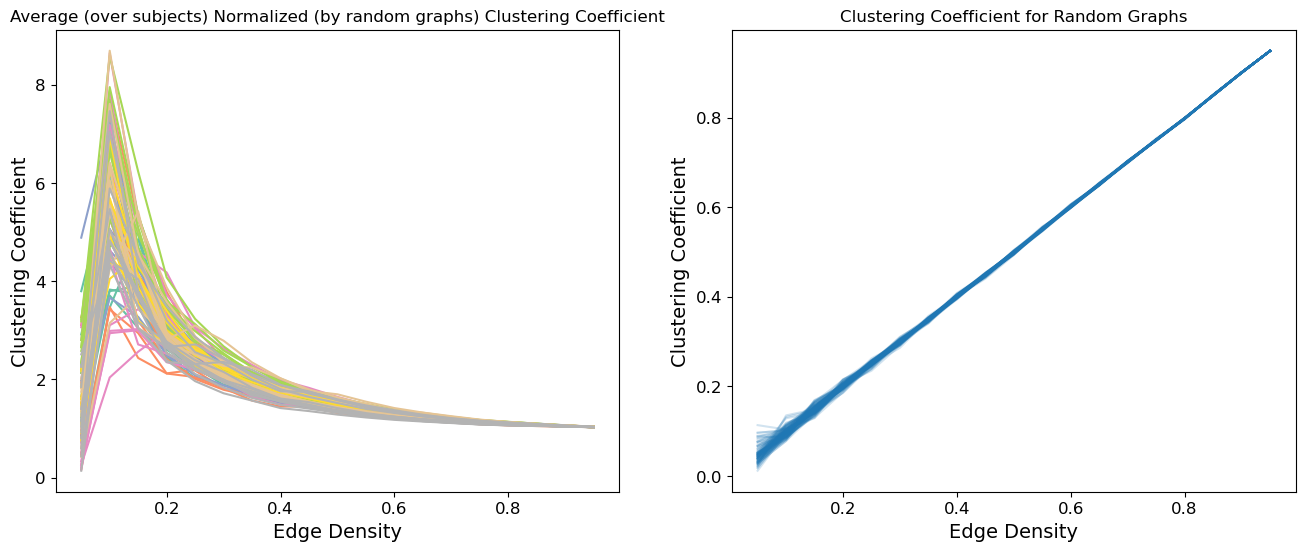

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

for node in range(n_nodes):
    axes[0].plot(all_rho, c_average[:, node], color=cmap(node))
axes[0].set_title("Average (over subjects) Normalized (by random graphs) Clustering Coefficient")

axes[1].plot(all_rho, c_rand_average, color="tab:blue", alpha=0.2)
axes[1].set_title("Clustering Coefficient for Random Graphs")

for ax in axes:
    ax.set_xlabel("Edge Density",fontsize=14)
    ax.set_ylabel("Clustering Coefficient",fontsize=14)
    ax.tick_params(labelsize=12)

As you might have observed before, there is a spike in clustering coefficient around edge density $\rho=0.15$ that is even more apparent when compared with random graphs. What does it mean ?


<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Small Worldness of Brain Graphs</b></p>
        <p style='text-indent: 10px;'> The fact that for such small edge densities, the ratio of the real (measured) to random graph clustering coefficient is much larger than 1 is an evidence that the brain is structured. Why ? Because it means that the information flows more efficiently than in a random network. This means that the brain is a small world network, but let us remember that we also need to consider the path length.
    </span>
</div>

---

We will now observe what happens to the clustering coefficient when nodes of the network are sequentially removed, but we have to distinguish two cases: 
 * one in which nodes are randomly removed,
 * one in which nodes are removed by starting with the ones with higher degree.

For an edge density of $0.3$, we compute the average nodal clustering coefficient across nodes for each subject, sequentially removing one node at a time. 

In [25]:
rho = 0.3
c_rem_rand = np.zeros((n_subjects, n_nodes - 1))
c_rem_deg = np.zeros((n_subjects, n_nodes - 1))
for sub, mat in enumerate(fc_matrices):
    adj_rand = BinarizeAdjacency(np.squeeze(mat), rho).astype(int)
    adj_deg = adj_rand.copy()

    for i in range(n_nodes - 1):
        node = np.random.randint(0, adj_rand.shape[0])
        adj_rand = np.delete(adj_rand, node, axis=0)
        adj_rand = np.delete(adj_rand, node, axis=1)
        c_rem_rand[sub, i] = np.mean(ClustCoef(adj_rand))
        
        # We actually need to recompute the degree at each step to account for removed nodes (and edges)
        deg = adj_deg.sum(axis=0)
        node = np.argmax(deg)
        adj_deg = np.delete(adj_deg, node, axis=0)
        adj_deg = np.delete(adj_deg, node, axis=1)
        c_rem_deg[sub, i] = np.mean(ClustCoef(adj_deg))

Text(0.5, 1.0, 'node-averaged clustering coefficient for subject graphs')

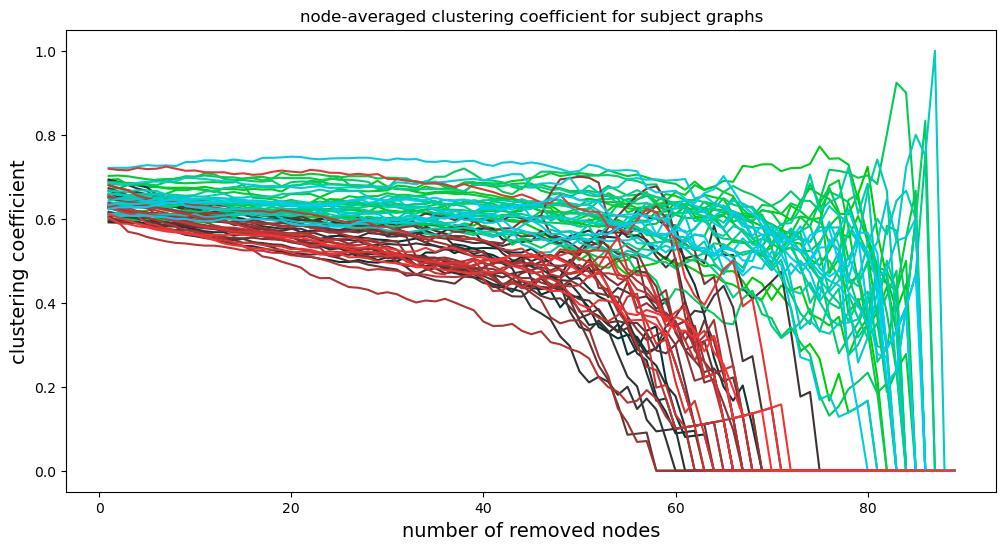

In [26]:
fig, axes = plt.subplots(figsize=(12, 6))

for sub in range(n_subjects):
    axes.plot(np.arange(1, 90), c_rem_rand[sub,:], color=[0, 0.8, sub/n_subjects])
    axes.plot(np.arange(1, 90), c_rem_deg[sub,:], color=[sub/n_subjects, 0.2, 0.2])

axes.set_xlabel("number of removed nodes", fontsize=14)
axes.set_ylabel("clustering coefficient", fontsize=14)
axes.set_title("node-averaged clustering coefficient for subject graphs")

<div class = 'alert alert-info'>
    
**Note:** Each subject's graph corresponds to two lines: one *blue-ish* for random node removal, and one *red-ish* for highest degree node removal.
</div>

Green-blue colors refer to the random node removal case, while red-black colors denote high degree nodes removal (each line represents the graph of a participant). While there is a general decrease of the clustering coefficient as we gradually remove nodes (and the associated edges), are there any differences between the random and high-degree removals ? What could explain these ?

<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Hubs in Brain Graphs</b></p>
        <p style='text-indent: 10px;'> It is clear that the high-degree removal curves reach zero faster, which means that local information flow (as quantified by the clustering coefficient) suffers more from the exclusion of high-degree nodes from the network.

This highlights the fact that there is a subset of brain regions that are particularly important to maintain correct brain functional architecture: <b>graph hubs</b>. These hubs usually contribute to both local information flow, and long-distance interactions and we would expect the same type of outcome when considering the path length.
    </span>
</div>

---

## 2.3 Playing with the Graph Laplacian

Finally, you briefly saw in the lecture that the graph Laplacian $\mathbf{L}$ is powerful operator to understand the structure and topology of a graph as well as how signal (e.g., brain activity) is "using" that underlying structure. Specifically, you saw that the eigenvector $\mathbf{v}_{i}$ that corresponds to the smallest non-zero eigenvalue $\lambda_{i}$ of the graph Laplacian (AKA the *Fiedler vector*) solves the graph-cut optimization problem (best separation of a graph in two sets of nodes). Furthermore, eigenvectors that correspond small eigenvalues tend to describe oscillatory pattern of "low spatial frequency" within the network. Let's have look at some of these eigenvectors !

- Your task is first to generate a group average functional connectome (stored in `sub_avg`). Then, following the definition seen in the lecture, compure the graph Laplacian of the group average connectome and extract its eigenvalues and eigenvectors.

<div class = 'alert alert-info'>

**Hint:** You can manually implement the computation of the Laplacian or (again) have a look at [<i>NetworkX</i>'s methods](https://networkx.org/documentation/stable/reference/linalg.html#module-networkx.linalg.laplacianmatrix). Be careful of the output format, we expect the laplacian matrix to be a `numpy.array`. Also note that there is a method to compute eigenvalues and eigenvectors in [`np.linalg`](https://numpy.org/doc/stable/reference/routines.linalg.html#matrix-eigenvalues).

**Note 1:** There are different [definition of the graph Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix) (e.g., combinatorial, symmetrically normalized), feel free to experiment with these different definitions and pick the one with the prettiest results (we recommend the normalized Laplacian ;) ).

**Note 2:** You may also experiment with different adjacency matrices by considering the:
* fully weighted connectivity matrix,
* binarized version,
* or our own favorite: binarized version multiplied by the original weights (weighted graph where the weak edges have beed removed).

</div>

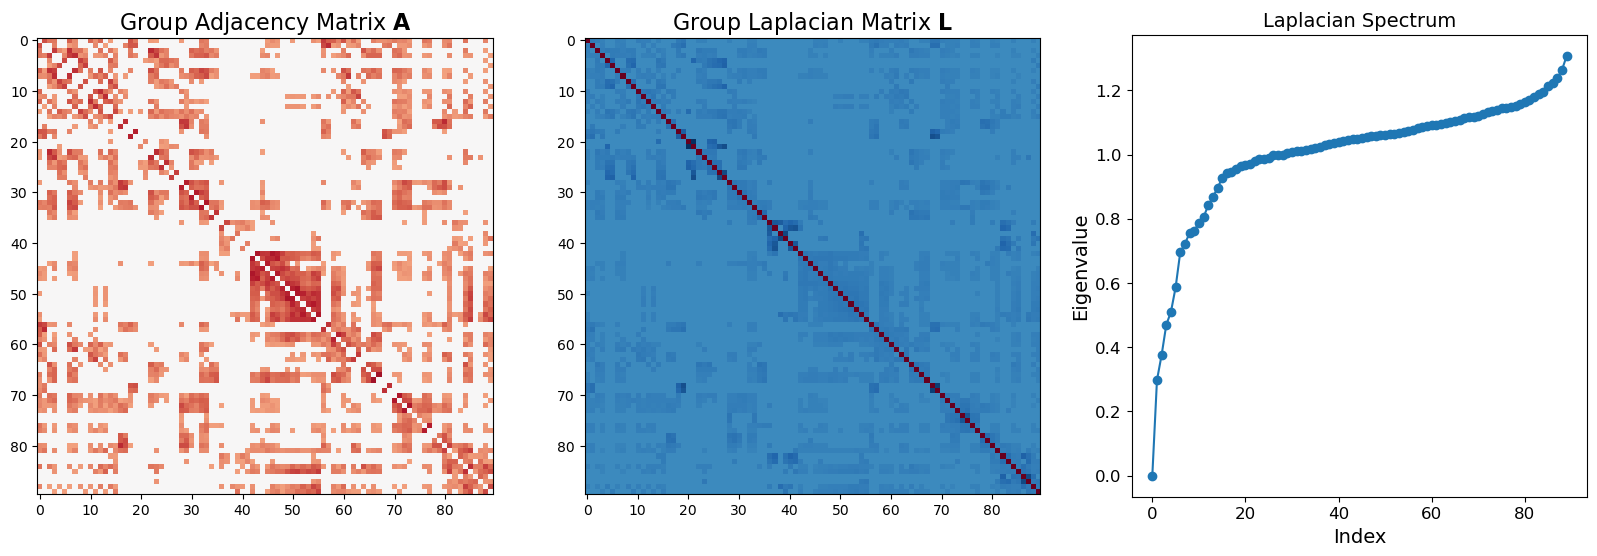

In [27]:
### YOUR CODE HERE
sub_avg = np.mean(fc_matrices, axis=0) ### YOUR CODE HERE
sub_avg *= BinarizeAdjacency(sub_avg, 0.3)
### END OF SOLUTION

n_nodes = len(sub_avg)
graph = nx.Graph(sub_avg)

### YOUR CODE HERE
avg_lap = nx.linalg.normalized_laplacian_matrix(graph).toarray()
# avg_lap = nx.linalg.laplacian_matrix(graph).toarray()
eigenvalues, eigenvectors = np.linalg.eig(avg_lap)
### END OF SOLUTION

sorting_ids = np.argsort(eigenvalues)
eigenvalues = eigenvalues.real[sorting_ids]
eigenvectors = eigenvectors[:, sorting_ids].real

fig, axes = plt.subplots(ncols=3, figsize=(20, 6))
axes[0].imshow(sub_avg, cmap="RdBu_r", vmin=-1, vmax=1)
axes[0].set_title("Group Adjacency Matrix $\mathbf{{A}}$", fontsize=16)

axes[1].imshow(avg_lap, cmap="RdBu_r")
axes[1].set_title("Group Laplacian Matrix $\mathbf{{L}}$", fontsize=16)

axes[2].plot(eigenvalues, 'o-')
axes[2].set_xlabel("Index", fontsize=14)
axes[2].set_ylabel("Eigenvalue", fontsize=14)
axes[2].set_title("Laplacian Spectrum", fontsize=14)
axes[2].tick_params(labelsize=12)

Just looking at the Laplacian matrix is not very informative but the *eigenspectrum* gives information about the graph spatial frequencies of the network. Let's look at these so called "low spatial frequency" patterns !

<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Graph Laplacian Fun Fact</b></p>
        <p style='text-indent: 10px;'> Did you know that the number of zero eigenvalues of the graph Laplacian is equal to the number of connected components in the network ? So even if your graph is one connected components, there will always be one eigenvalue with value 0. Quite useful for network analysis, right ?
    </span>
</div>

<Axes: xlabel='Fiedler Vector', ylabel='Eigenvector 3'>

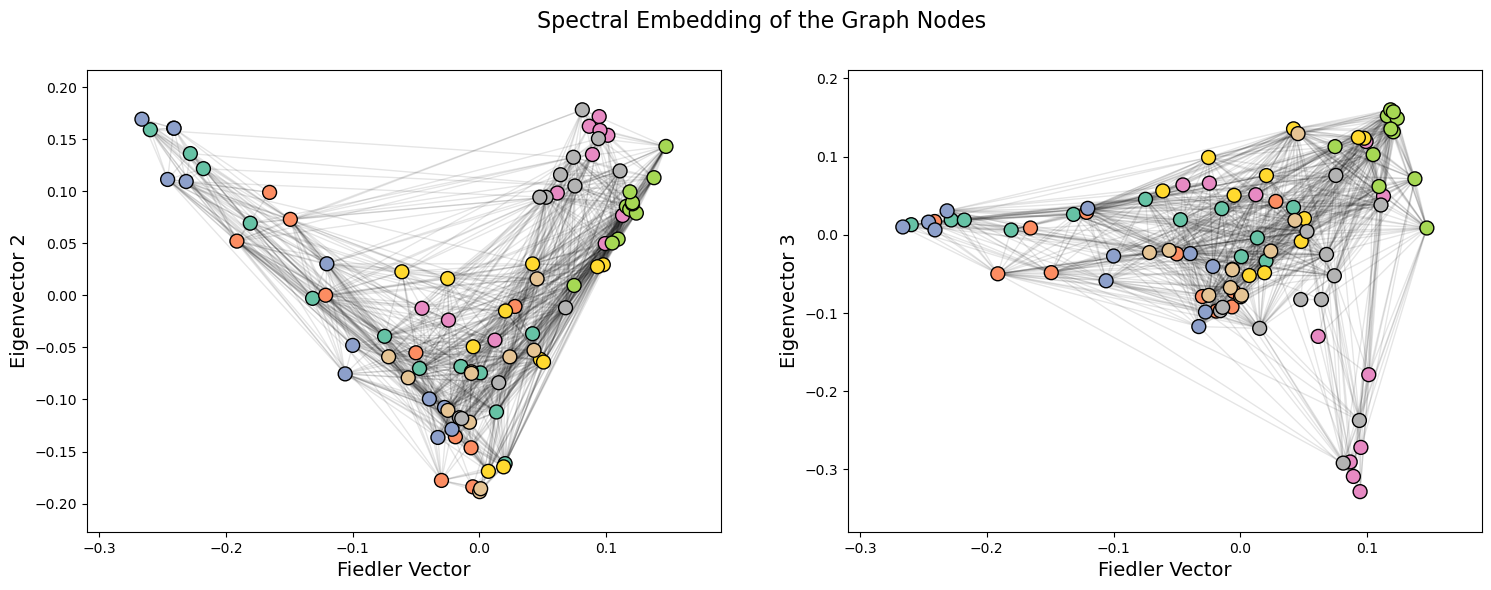

In [28]:
def plot_spectral_embedding(eigvec, ax, x_id=1, y_id=2, edge_alpha=0.1):
    ax.scatter(eigvec[:, x_id].real, eigvec[:, y_id].real,
                    c=np.arange(n_nodes), s=100, cmap="Set2", edgecolor="k", zorder=2)
    
    graph_pos = {i: (eig[x_id], eig[y_id]) for i, eig in enumerate(eigvec)}
    nx.draw_networkx_edges(graph, pos=graph_pos, alpha=edge_alpha, ax=ax)
    
    if x_id == 1:
        ax.set_xlabel("Fiedler Vector", fontsize=14)
    else:
        ax.set_xlabel(f"Eigenvector {x_id}", fontsize=14)
    
    if y_id == 1:
        ax.set_ylabel("Fiedler Vector", fontsize=14)
    else:
        ax.set_ylabel(f"Eigenvector {y_id}", fontsize=14)

    ax.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
    
    return ax

fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

fig.suptitle(f"Spectral Embedding of the Graph Nodes", fontsize=16)
plot_spectral_embedding(eigenvectors, axes[0], x_id=1, y_id=2, edge_alpha=0.1)
plot_spectral_embedding(eigenvectors, axes[1], x_id=1, y_id=3, edge_alpha=0.1)

These nice maps already tell a lot about the functional organization of the brain by showing which regions tend to be closely connected together. For example, the first two non-zero eigenvectors of the connecome of the C.Elegans (a earthworm) already captures the sensory-to-motor flow of information as well as the head-body-tail axis of communication (see [Varshney, et al. 2011](https://pubmed.ncbi.nlm.nih.gov/21304930/#&gid=article-figures&pid=figure-2-uid-1)). But we are diverging... Let's have a look at these eigenvectors on the brain !

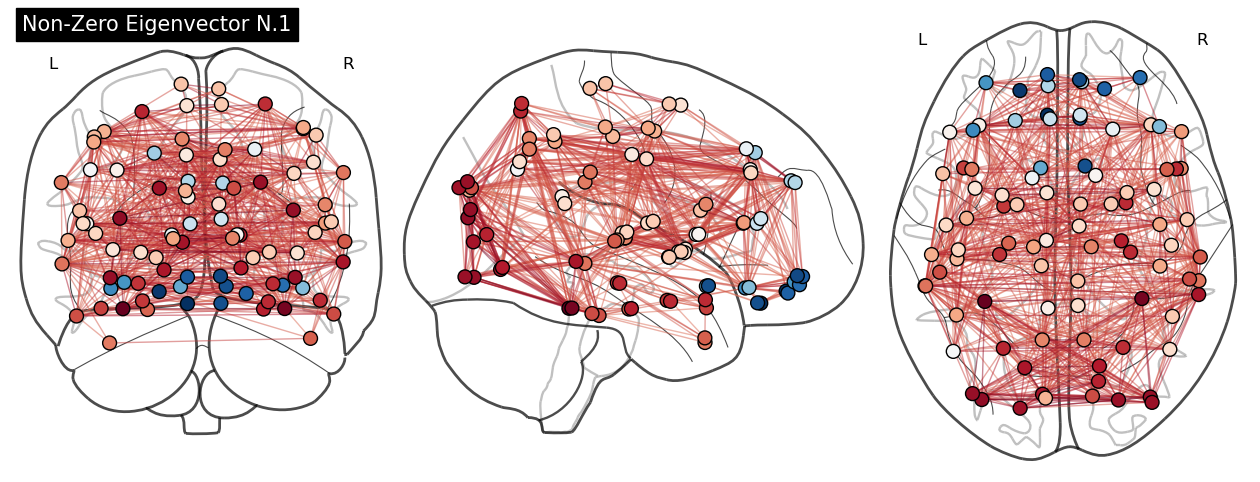

In [29]:
# Feel free to choose the eigenvectors used for embedding
eigvec_id = 1

fig, axes = plt.subplots(figsize=(16, 6))

embedding = eigenvectors[:, eigvec_id]
# Normalizing the embedding to [0-1]
embedding = (embedding - np.min(embedding)) / (np.max(embedding) - np.min(embedding))

plot_connectome(sub_avg,
                node_coords = aal_regions_info[['x', 'y', 'z']].values,
                node_color=embedding, node_size=100,
                edge_threshold='80%',
                title=f"Non-Zero Eigenvector N.{eigvec_id}",
                edge_kwargs={'alpha':0.5, 'linewidth': 1},
                node_kwargs={'cmap':'RdBu_r', 'edgecolor':'k', 'vmin':0, 'vmax':1},
                colorbar=False,
                axes=axes)

Beautiful maps, rights ? What can you say about the graph cut proposed by the Fiedler vector ? Does it represent any particular lobes or axes that are relevant to brain anatomy or function ?

Feel free to play around with the matrices and parameters to get the best visualization !


<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Congratulation, you made it to the end of the connectomics labs!</b></p>
        <p style='text-indent: 10px; text-align:center'> If you liked it, this last part is closely related to the research we do at MIP:Lab so feel free to reach out if you wish to know more or to take part in a student project !
    </span>
</div>